# Задание 5.1 - Word2Vec

В этом задании мы натренируем свои word vectors на очень небольшом датасете.
Мы будем использовать самую простую версию word2vec, без negative sampling и других оптимизаций.

Перед запуском нужно запустить скрипт `download_data.sh` чтобы скачать данные.

Датасет и модель очень небольшие, поэтому это задание можно выполнить и без GPU.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset

from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt

# We'll use Principal Component Analysis (PCA) to visualize word vectors,
# so make sure you install dependencies from requirements.txt!
from sklearn.decomposition import PCA

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!wget http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip
!unzip stanfordSentimentTreebank.zip
!rm stanfordSentimentTreebank.zip


--2023-07-02 15:47:17--  http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cs.stanford.edu/srcf_404 [following]
--2023-07-02 15:47:17--  https://cs.stanford.edu/srcf_404
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘stanfordSentimentTreebank.zip’

stanfordSentimentTr     [ <=>                ]  39.77K  --.-KB/s    in 0.02s   

2023-07-02 15:47:17 (2.02 MB/s) - ‘stanfordSentimentTreebank.zip’ saved [40722]

Archive:  stanfordSentimentTreebank.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  

In [4]:
device = torch.device("cuda:0")
device

device(type='cuda', index=0)

In [5]:
import os
import numpy as np

class StanfordTreeBank:
    '''
    Wrapper for accessing Stanford Tree Bank Dataset
    https://nlp.stanford.edu/sentiment/treebank.html

    Parses dataset, gives each token and index and provides lookups
    from string token to index and back

    Allows to generate random context with sampling strategy described in
    word2vec paper:
    https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf
    '''
    def __init__(self):
        self.index_by_token = {}
        self.token_by_index = []

        self.sentences = []

        self.token_freq = {}

        self.token_reject_by_index = None

    def load_dataset(self, folder):
        filename = os.path.join(folder, "datasetSentences.txt")

        with open(filename, "r", encoding="latin1") as f:
            l = f.readline() # skip the first line

            for l in f:
                splitted_line = l.strip().split()
                words = [w.lower() for w in splitted_line[1:]] # First one is a number

                self.sentences.append(words)
                for word in words:
                    if word in self.token_freq:
                        self.token_freq[word] +=1
                    else:
                        index = len(self.token_by_index)
                        self.token_freq[word] = 1
                        self.index_by_token[word] = index
                        self.token_by_index.append(word)
        self.compute_token_prob()

    def compute_token_prob(self):
        words_count = np.array([self.token_freq[token] for token in self.token_by_index])
        words_freq = words_count / np.sum(words_count)

        # Following sampling strategy from word2vec paper:
        # https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf
        self.token_reject_by_index = 1 - np.sqrt(1e-5/words_freq)

    def check_reject(self, word):
        return np.random.rand() > self.token_reject_by_index[self.index_by_token[word]]

    def get_random_context(self, context_length=5):
        """
        Returns tuple of center word and list of context words
        """
        sentence_sampled = []
        while len(sentence_sampled) <= 2:
            sentence_index = np.random.randint(len(self.sentences))
            sentence = self.sentences[sentence_index]
            sentence_sampled = [word for word in sentence if self.check_reject(word)]

        center_word_index = np.random.randint(len(sentence_sampled))

        words_before = sentence_sampled[max(center_word_index - context_length//2,0):center_word_index]
        words_after = sentence_sampled[center_word_index+1: center_word_index+1+context_length//2]

        return sentence_sampled[center_word_index], words_before+words_after

    def num_tokens(self):
        return len(self.token_by_index)

data = StanfordTreeBank()
data.load_dataset("/content/drive/MyDrive/Colab Notebooks/DL/stanfordSentimentTreebank/")

print("Num tokens:", data.num_tokens())
for i in range(5):
    center_word, other_words = data.get_random_context(5)
    print(center_word, other_words)

Num tokens: 19538
haynes ['without', 'camp', 'sirk', 'differently']
who ['linklater', 'fans', 'want', 'appear']
empathy ['trace', 'humanity']
aaa ['adrenalin', 'rated']
jokester ['status', 'punchline']


# Имплеменируем PyTorch-style Dataset для Word2Vec

Этот Dataset должен сгенерировать много случайных контекстов и превратить их в сэмплы для тренировки.

Напоминаем, что word2vec модель получает на вход One-hot вектор слова и тренирует простую сеть для предсказания на его основе соседних слов.
Из набора слово-контекст создается N сэмплов (где N - количество слов в контексте):

Например:

Слово: `orders` и контекст: `['love', 'nicest', 'to', '50-year']` создадут 4 сэмпла:
- input: `orders`, target: `love`
- input: `orders`, target: `nicest`
- input: `orders`, target: `to`
- input: `orders`, target: `50-year`

Все слова на входе и на выходе закодированы через one-hot encoding, с размером вектора равным количеству токенов.

In [6]:
one_hot_vector = np.zeros(data.num_tokens())
print(data.num_tokens())
data.token_by_index[1]

19538


'rock'

In [7]:
class Word2VecPlain(Dataset):
    '''
    PyTorch Dataset for plain Word2Vec.
    Accepts StanfordTreebank as data and is able to generate dataset based on
    a number of random contexts
    '''
    def __init__(self, data, num_contexts=30000, context_length=None):
        '''
        Initializes Word2VecPlain, but doesn't generate the samples yet
        (for that, use generate_dataset)
        Arguments:
        data - StanfordTreebank instace
        num_contexts - number of random contexts to use when generating a dataset
        '''
        # TODO: Implement what you need for other methods!
        self.dataset = data
        self.num_context = num_contexts
        self.num_tokens = data.num_tokens()
        self.context_length = None
        self.samples = []
        if context_length is not None:
            self.context_length = context_length

    def generate_dataset(self):
        '''
        Generates dataset samples from random contexts
        Note: there will be more samples than contexts because every context
        can generate more than one sample
        '''
        # TODO: Implement generating the dataset
        # You should sample num_contexts contexts from the data and turn them into samples
        # Note you will have several samples from one context

        # refresh
        self.samples = []

        for i in range(self.num_context):
            if self.context_length is not None:
                center_word, context = self.dataset.get_random_context(self.context_length)
            else:
                center_word, context = self.dataset.get_random_context()

            for context_word in context:
                self.samples.append((self.dataset.index_by_token[center_word], self.dataset.index_by_token[context_word]))

    def __len__(self):
        '''
        Returns total number of samples
        '''
        # TODO: Return the number of samples
        return len(self.samples)

    def __getitem__(self, index):
        '''
        Returns i-th sample

        Return values:
        input_vector - torch.Tensor with one-hot representation of the input vector
        output_index - index of the target word (not torch.Tensor!)
        '''
        # TODO: Generate tuple of 2 return arguments for i-th sample
        center_word_index, context_word_index = self.samples[index]
        one_hot_vector = torch.zeros(self.dataset.num_tokens())
        # мы предсказываем контекст - поэтому целевой индекс - контекстное слово
        one_hot_vector[center_word_index] = 1
        return one_hot_vector, context_word_index

dataset = Word2VecPlain(data, 10)
dataset.generate_dataset()
input_vector, target = dataset[3]
print("Sample - input: %s, target: %s" % (input_vector, int(target))) # target should be able to convert to int
assert isinstance(input_vector, torch.Tensor)
assert torch.sum(input_vector) == 1.0
assert input_vector.shape[0] == data.num_tokens()

Sample - input: tensor([0., 0., 0.,  ..., 0., 0., 0.]), target: 7192


# Создаем модель и тренируем ее

In [8]:
# Create the usual PyTorch structures
dataset = Word2VecPlain(data, 30000)
dataset.generate_dataset()
print(len(dataset))

# We'll be training very small word vectors!
wordvec_dim = 10

# We can use a standard sequential model for this
nn_model = nn.Sequential(
            nn.Linear(dataset.num_tokens, wordvec_dim, bias=False),
            nn.Linear(wordvec_dim, dataset.num_tokens, bias=False),
         )
nn_model.type(torch.FloatTensor)
nn_model = nn_model.to(device)

82838


In [9]:
def extract_word_vectors(nn_model):
    '''
    Extracts word vectors from the model

    Returns:
    input_vectors: torch.Tensor with dimensions (num_tokens, num_dimensions)
    output_vectors: torch.Tensor with dimensions (num_tokens, num_dimensions)
    '''
    # TODO: Implement extracting word vectors from param weights
    # return tuple of input vectors and output vectos
    # Hint: you can access weights as Tensors through nn.Linear class attributes
    vectors = []
    layers = nn_model.children()
    # first_layer vector size: (num_tokens)
    # second_layer vector size: ()
    for layer in layers: #
        params = list(layer.parameters())
#         print(params)
        vectors.append(params[0])
    return vectors[0].T, vectors[1]

untrained_input_vectors, untrained_output_vectors = extract_word_vectors(nn_model)
print(untrained_input_vectors.shape, untrained_output_vectors.shape)
assert untrained_input_vectors.shape == (data.num_tokens(), wordvec_dim)
assert untrained_output_vectors.shape == (data.num_tokens(), wordvec_dim)

torch.Size([19538, 10]) torch.Size([19538, 10])


In [10]:
def train_model(model, dataset, train_loader, optimizer, scheduler, num_epochs):
    '''
    Trains plain word2vec using cross-entropy loss and regenerating dataset every epoch

    Returns:
    loss_history, train_history
    '''

    criterion = nn.CrossEntropyLoss().type(torch.FloatTensor)

    loss_history = []
    accuracy_history = []

    for epoch in range(num_epochs):
        model.train() # Enter train mode

        dataset.generate_dataset() # Regenerate dataset every epoch

        # TODO Implement training for this model
        # Note we don't have any validation set here because our purpose is the word vectors,
        # not the predictive performance of the model
        #
        # And don't forget to step the learing rate scheduler!

        train_loader = torch.utils.data.DataLoader(dataset, batch_size=20)

        total_loss = 0
        total_accuracy = 0
        total_samples = 0

        for idx, (_x, _y) in enumerate(train_loader):
            x, y = _x.to(device), _y.to(device)
            prediction = model(x)

            optimizer.zero_grad()
            loss = criterion(prediction, y)
            loss.backward()
            optimizer.step()

            total_loss += loss #  / len(y)
            total_accuracy += torch.sum(torch.argmax(prediction, dim=1) == y)
            total_samples += _y.shape[0]

        scheduler.step()

        ave_loss = total_loss / (idx + 1)
        train_accuracy = total_accuracy / (idx + 1)  # / total_samples

        loss_history.append(float(ave_loss))
        accuracy_history.append(float(train_accuracy))

        print("Epoch %i, Average loss: %f, Train accuracy: %f, learning rate value: %.3f" % (epoch, ave_loss, train_accuracy, scheduler.get_last_lr()[0]))  # , learning rate value: %f scheduler.get_lr()

    return loss_history, accuracy_history

# Ну и наконец тренировка!

Добейтесь значения ошибки меньше **8.0**.

In [11]:
# Finally, let's train the model!

# Create the usual PyTorch structures
dataset = Word2VecPlain(data, 30000)
dataset.generate_dataset()
print(len(dataset))

# We'll be training very small word vectors!
wordvec_dim = 10

# We can use a standard sequential model for this
nn_model = nn.Sequential(
            nn.Linear(dataset.num_tokens, wordvec_dim, bias=False),
            nn.Linear(wordvec_dim, dataset.num_tokens, bias=False),
         )
nn_model.type(torch.FloatTensor)
nn_model = nn_model.to(device)

# grid search

# TODO: We use placeholder values for hyperparameters - you will need to find better values!
optimizer = optim.SGD(nn_model.parameters(), lr=2, weight_decay=0.)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.9)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=20)

loss_history, train_history = train_model(nn_model, dataset, train_loader, optimizer, scheduler, 100)

82855
Epoch 0, Average loss: 9.876845, Train accuracy: 0.011580, learning rate value: 2.000
Epoch 1, Average loss: 9.868889, Train accuracy: 0.037539, learning rate value: 2.000
Epoch 2, Average loss: 9.848089, Train accuracy: 0.059831, learning rate value: 1.800
Epoch 3, Average loss: 9.781254, Train accuracy: 0.072324, learning rate value: 1.800
Epoch 4, Average loss: 9.667629, Train accuracy: 0.069672, learning rate value: 1.800
Epoch 5, Average loss: 9.564870, Train accuracy: 0.062304, learning rate value: 1.620
Epoch 6, Average loss: 9.481071, Train accuracy: 0.068391, learning rate value: 1.620
Epoch 7, Average loss: 9.418319, Train accuracy: 0.056909, learning rate value: 1.620
Epoch 8, Average loss: 9.371365, Train accuracy: 0.065700, learning rate value: 1.458
Epoch 9, Average loss: 9.314717, Train accuracy: 0.069672, learning rate value: 1.458
Epoch 10, Average loss: 9.270439, Train accuracy: 0.075545, learning rate value: 1.458
Epoch 11, Average loss: 9.219989, Train accurac

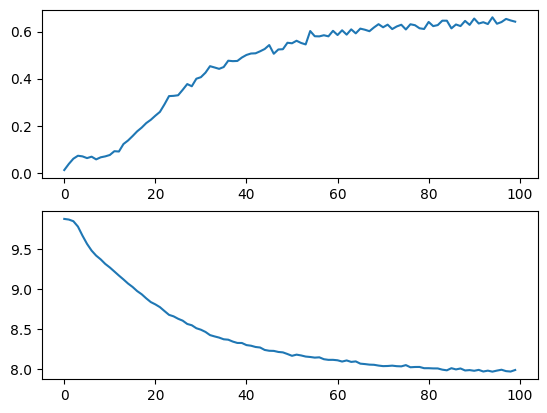

In [12]:
# Visualize training graphs
plt.subplot(211)
plt.plot(train_history)
plt.subplot(212)
plt.plot(loss_history)

# Визуализируем вектора для разного вида слов до и после тренировки

В случае успешной тренировки вы должны увидеть как вектора слов разных типов (например, знаков препинания, предлогов и остальных) разделяются семантически.

Студенты - в качестве выполненного задания присылайте notebook с диаграммами!

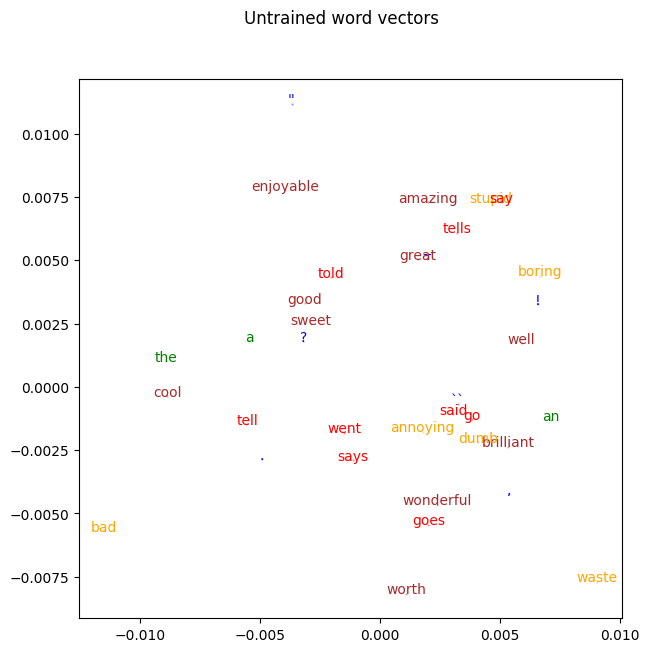

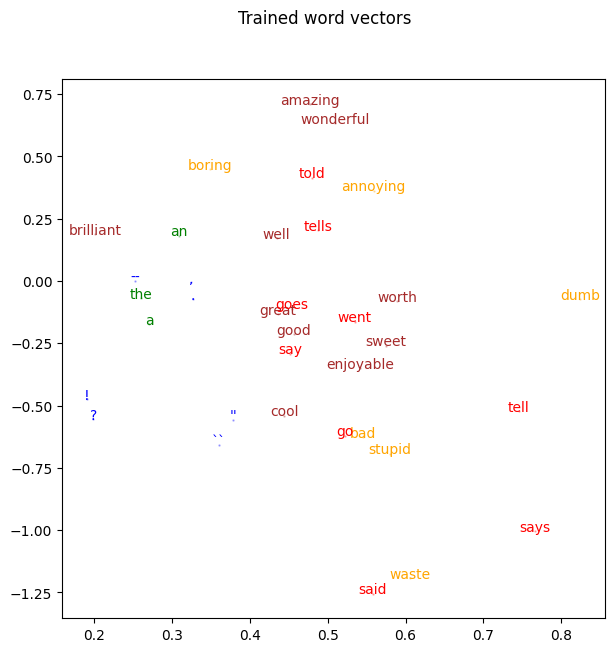

In [15]:
trained_input_vectors, trained_output_vectors = extract_word_vectors(nn_model)
# trained_input_vectors = trained_input_vectors.cpu() #.detach().numpy()
# trained_output_vectors = trained_output_vectors.cpu() #.detach().numpy()
assert trained_input_vectors.shape == (data.num_tokens(), wordvec_dim)
assert trained_output_vectors.shape == (data.num_tokens(), wordvec_dim)

def visualize_vectors(input_vectors, output_vectors, title=''):
    full_vectors = torch.cat((input_vectors, output_vectors), 0)
    wordvec_embedding = PCA(n_components=2).fit_transform(full_vectors.detach().numpy())

    # Helpful words form CS244D example
    # http://cs224d.stanford.edu/assignment1/index.html
    visualize_words = {'green': ["the", "a", "an"],
                      'blue': [",", ".", "?", "!", "``", "''", "--"],
                      'brown': ["good", "great", "cool", "brilliant", "wonderful",
                              "well", "amazing", "worth", "sweet", "enjoyable"],
                      'orange': ["boring", "bad", "waste", "dumb", "annoying", "stupid"],
                      'red': ['tell', 'told', 'said', 'say', 'says', 'tells', 'goes', 'go', 'went']
                     }

    plt.figure(figsize=(7,7))
    plt.suptitle(title)
    for color, words in visualize_words.items():
        points = np.array([wordvec_embedding[data.index_by_token[w]] for w in words])
        for i, word in enumerate(words):
            plt.text(points[i, 0], points[i, 1], word, color=color,horizontalalignment='center')
        plt.scatter(points[:, 0], points[:, 1], c=color, alpha=0.3, s=0.5)

visualize_vectors(untrained_input_vectors.cpu(), untrained_output_vectors.cpu(), "Untrained word vectors")
visualize_vectors(trained_input_vectors.cpu(), trained_output_vectors.cpu(), "Trained word vectors")